In [1]:
import numpy as np
import xarray as xr
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature
import pandas as pd
from sklearn.decomposition import pca
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
from scipy import interpolate
import seaborn as sns

from MapXtremePCIC import MapXtremePCIC

In [2]:
PATH = './data/pr_24hr_50yrs/'

MapXtreme = MapXtremePCIC('110m', 'eof', PATH, 'pr')
data_cube = MapXtreme.read_data()

In [3]:
df_obs = MapXtreme.get_pseudo_obs()
df_model = MapXtreme.standard_matrix(MapXtreme.ensemble_mean(MapXtreme.get_df())).dropna()

         areas       rlat       rlon
0  1772.265835 -27.279999 -32.560013
1  1780.387597 -27.279999 -32.119995
2  1788.304531 -27.279999 -31.679993
3  1796.161150 -27.279999 -31.239990
4  1804.299786 -27.279999 -30.800003
   run0  run1  run2  run3  run4  run5  run6  run7  run8  run9  ...    run25  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...      NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...      NaN   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...      NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...      NaN   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...      NaN   

   run26  run27  run28  run29  run30  run31  run32  run33  run34  
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
3    NaN    NaN    NaN    NaN    Na

In [4]:
df_combined = MapXtreme.combine_model_obs(df_obs, df_model)
df_combined_dna = df_combined.dropna()
df_combined_dna.head()

,areas,rlat,rlon,run0,run1,run2,run3,run4,run5,run6,...,run28,run29,run30,run31,run32,run33,run34,run_pseudo,rlat_copy,rlon_copy
80,2114.725982,-26.399998,7.919998,-0.000016,-0.000007,0.000054,2.924031e-05,-0.000011,0.000048,-0.000019,...,0.000048,-0.000010,0.000038,0.000009,-0.000025,0.000016,6.999534e-07,-0.000016,-26.399998,7.919998
95,2138.145418,-25.959999,-5.280014,0.000008,0.000012,0.000058,-9.550747e-06,-0.000021,-0.000002,-0.000038,...,-0.000020,0.000042,0.000015,-0.000004,-0.000009,0.000016,-1.695237e-05,0.000008,-25.959999,-5.280014
221,1884.334521,-24.199999,28.160004,0.000003,-0.000028,-0.000019,7.297852e-07,0.000011,0.000020,-0.000003,...,0.000025,-0.000009,0.000027,-0.000001,0.000018,-0.000015,-7.102036e-07,0.000004,-24.199999,28.160004
239,2186.112203,-23.759996,-1.759995,0.000018,0.000037,-0.000064,-4.707592e-06,-0.000023,0.000101,0.000038,...,0.000006,-0.000034,0.000023,-0.000022,0.000005,0.000022,-2.300295e-05,0.000017,-23.759996,-1.759995
304,2046.680888,-23.319998,18.919998,-0.000051,-0.000022,-0.000045,4.860976e-07,-0.000057,-0.000004,0.000014,...,0.000047,0.000035,0.000024,0.000003,-0.000068,-0.000073,5.305413e-05,-0.000050,-23.319998,18.919998


,areas,rlat,rlon,run0,run1,run2,run3,run4,run5,run6,...,run27,run28,run29,run30,run31,run32,run33,run34,rlat_copy,rlon_copy
80,2114.725982,-26.399998,7.919998,-0.000016,-0.000007,0.000054,2.924031e-05,-0.000011,0.000048,-0.000019,...,-0.000019,0.000048,-0.000010,0.000038,0.000009,-0.000025,0.000016,6.999534e-07,-26.399998,7.919998
95,2138.145418,-25.959999,-5.280014,0.000008,0.000012,0.000058,-9.550747e-06,-0.000021,-0.000002,-0.000038,...,0.000002,-0.000020,0.000042,0.000015,-0.000004,-0.000009,0.000016,-1.695237e-05,-25.959999,-5.280014
221,1884.334521,-24.199999,28.160004,0.000003,-0.000028,-0.000019,7.297852e-07,0.000011,0.000020,-0.000003,...,0.000004,0.000025,-0.000009,0.000027,-0.000001,0.000018,-0.000015,-7.102036e-07,-24.199999,28.160004
239,2186.112203,-23.759996,-1.759995,0.000018,0.000037,-0.000064,-4.707592e-06,-0.000023,0.000101,0.000038,...,0.000045,0.000006,-0.000034,0.000023,-0.000022,0.000005,0.000022,-2.300295e-05,-23.759996,-1.759995
304,2046.680888,-23.319998,18.919998,-0.000051,-0.000022,-0.000045,4.860976e-07,-0.000057,-0.000004,0.000014,...,0.000009,0.000047,0.000035,0.000024,0.000003,-0.000068,-0.000073,5.305413e-05,-23.319998,18.919998


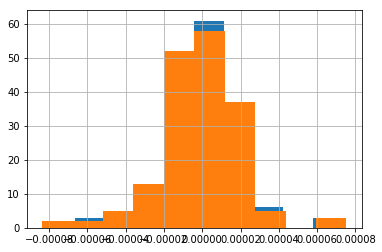

In [5]:
y_g = df_combined_dna['run_pseudo'].values

df_field = df_combined_dna.loc[:, df_combined_dna.columns != 'run_pseudo']

n_field, p_field, X_field = MapXtreme.get_arr(df_field)

df_field['run0'].hist()
plt.plot()
df_combined['run_pseudo'].hist()
plt.plot()

df_field.head()

In [6]:
df_field_full = df_combined.loc[:, df_combined.columns != 'run_pseudo']
n_full, p_full, X_full = MapXtreme.get_arr(df_field_full)
df_field_full.head()

,areas,rlat,rlon,run0,run1,run2,run3,run4,run5,run6,...,run27,run28,run29,run30,run31,run32,run33,run34,rlat_copy,rlon_copy
0,2095.101538,-27.279999,-8.800003,-0.000029,-0.000003,-0.000011,0.000105,-0.000045,-0.000063,-0.000051,...,0.000051,-0.000034,0.000048,0.000093,0.000055,-0.000045,0.000022,0.000009,NaN,NaN
1,2097.951178,-27.279999,-8.360016,-0.000069,-0.000034,0.000034,0.000145,-0.000033,-0.000050,-0.000059,...,0.000152,-0.000071,0.000052,0.000091,0.000037,-0.000063,-0.000032,0.000024,NaN,NaN
2,2100.735570,-27.279999,-7.919998,-0.000058,-0.000072,0.000137,0.000040,-0.000002,0.000014,-0.000093,...,0.000059,-0.000042,0.000052,0.000130,0.000035,-0.000059,-0.000044,0.000063,NaN,NaN
3,2103.285664,-27.279999,-7.480011,0.000001,-0.000057,0.000099,0.000046,-0.000010,-0.000007,-0.000029,...,0.000076,-0.000034,0.000121,0.000058,0.000039,-0.000036,-0.000062,0.000052,NaN,NaN
4,2105.743245,-27.279999,-7.039993,-0.000049,-0.000083,0.000003,0.000010,-0.000052,-0.000003,-0.000061,...,0.000022,0.000004,0.000086,0.000008,0.000102,0.000010,-0.000034,-0.000036,NaN,NaN


In [30]:
ys = np.reshape(np.tile(y_g, n_field), (y_g.shape[0], n_field))

skpca = pca.PCA(0.95)
pcs = skpca.fit_transform(X_field.T)
#pcs = skpca.components_[:pcs.shape[0], :]

obs = skpca.transform(ys)

full = skpca.transform(X_full.T)

obs.shape, pcs.shape, full.shape

((177, 29), (177, 29), (8843, 29))

In [27]:
obs_full = np.ones(full.shape)
for run in range(0, obs_full.shape[1]):
    f = interpolate.interp1d(pcs[:, run], obs[:, run], fill_value='extrapolate')
    obs_full[:, run] = f(full[:, run])
    #print(obs_full.shape)
    obs_full_new = skpca.inverse_transform(obs_full.T)

#df_model.head()

#obs_full = skpca.inverse_transform(obs_full)
#obs_full.shape

df_model['run_full_eof'] = obs_full_new[:, 0]

ValueError: x and y arrays must be equal in length along interpolation axis.

In [9]:
df_recon = MapXtreme.standard_matrix(df_model, reverse = True)
#df_recon = df_recon[np.isfinite(df_recon['run_full_eof'])]
df_recon.shape

         areas       rlat       rlon
0  1772.265835 -27.279999 -32.560013
1  1780.387597 -27.279999 -32.119995
2  1788.304531 -27.279999 -31.679993
3  1796.161150 -27.279999 -31.239990
4  1804.299786 -27.279999 -30.800003
   run0  run1  run2  run3  run4  run5  run6  run7  run8  run9      ...       \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN      ...        
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN      ...        
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN      ...        
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN      ...        
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN      ...        

   run26  run27  run28  run29  run30  run31  run32  run33  run34  run_full_eof  
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN           NaN  
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN           NaN  
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

(18204, 39)

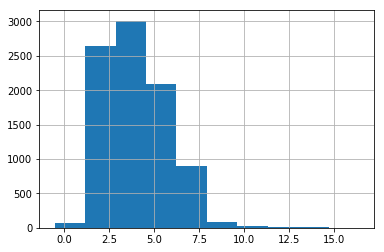

In [10]:
df_recon['run_full_eof'].hist()

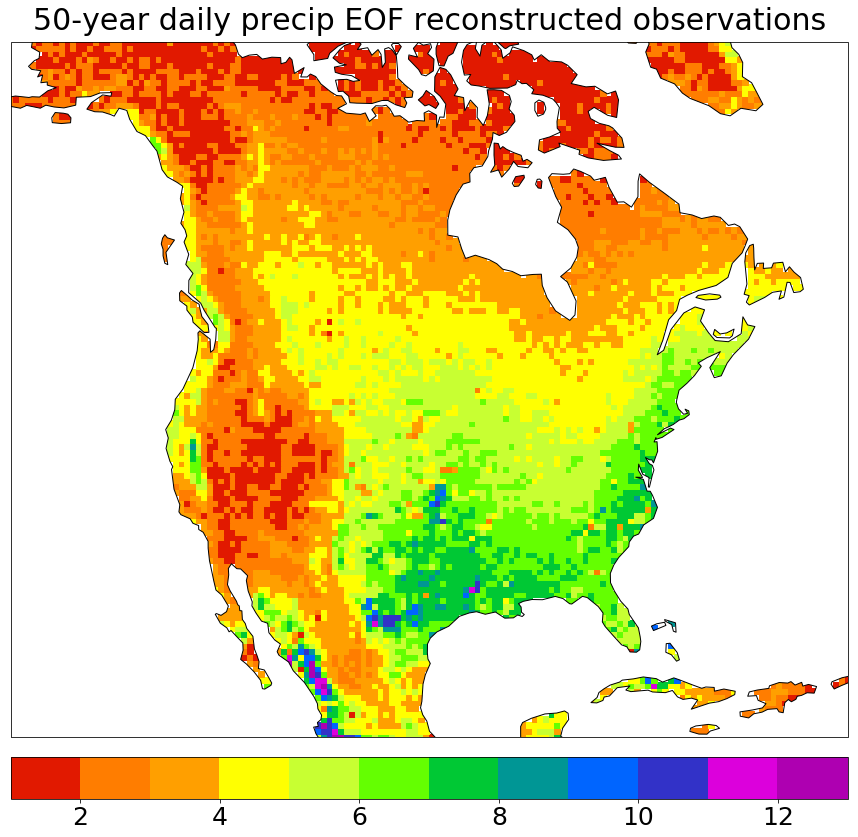

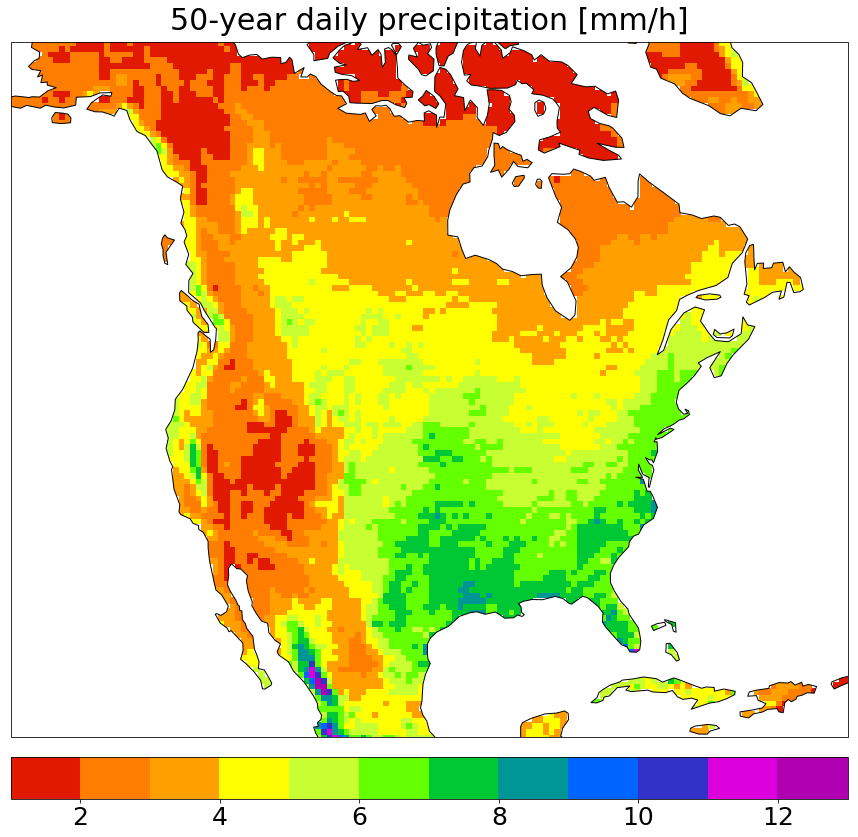

In [11]:
ax = MapXtreme.plot_reference(df = df_recon, run = 'run_full_eof', plot_title='50-year daily precip EOF reconstructed observations', save_fig = True)

ax1 = MapXtreme.plot_reference(df = df_recon, run = 'run0', save_fig = True)

In [18]:
df = MapXtreme.get_df()
df = df.merge(df_recon, how = 'outer', on = ['rlat', 'rlon']).copy()

#df = pd.concat([MapXtreme.get_df(), df_recon], axis = 1).copy()

print(df.shape)

N_lon = 10*df['rlon'].unique().shape[0]
N_lat = 10*df['rlat'].unique().shape[0]

z = np.reshape(df['run_full_eof'].interpolate(method='nearest').fillna(0.0).values, (df['rlat'].unique().shape[0], df['rlon'].unique().shape[0]))

new_lon = np.linspace(df['rlon'].min(), df['rlon'].max(), N_lon)
new_lat = np.linspace(df['rlat'].min(), df['rlat'].max(), N_lat)

print(z.shape)

#interp
new_grid=interpolate.interp2d(df['rlon'].unique(), df['rlat'].unique(), z, kind = 'cubic')

(18204, 75)
(123, 148)


In [19]:
df_interp = pd.DataFrame()
df_interp['rlat'] = np.repeat(new_lat, N_lon)
df_interp['rlon'] = np.tile(new_lon, N_lat)

new_z = new_grid(new_lon, new_lat)
new_z.shape
df_interp['run_full_eof_interp'] = np.reshape(new_z, new_z.shape[0]*new_z.shape[1])

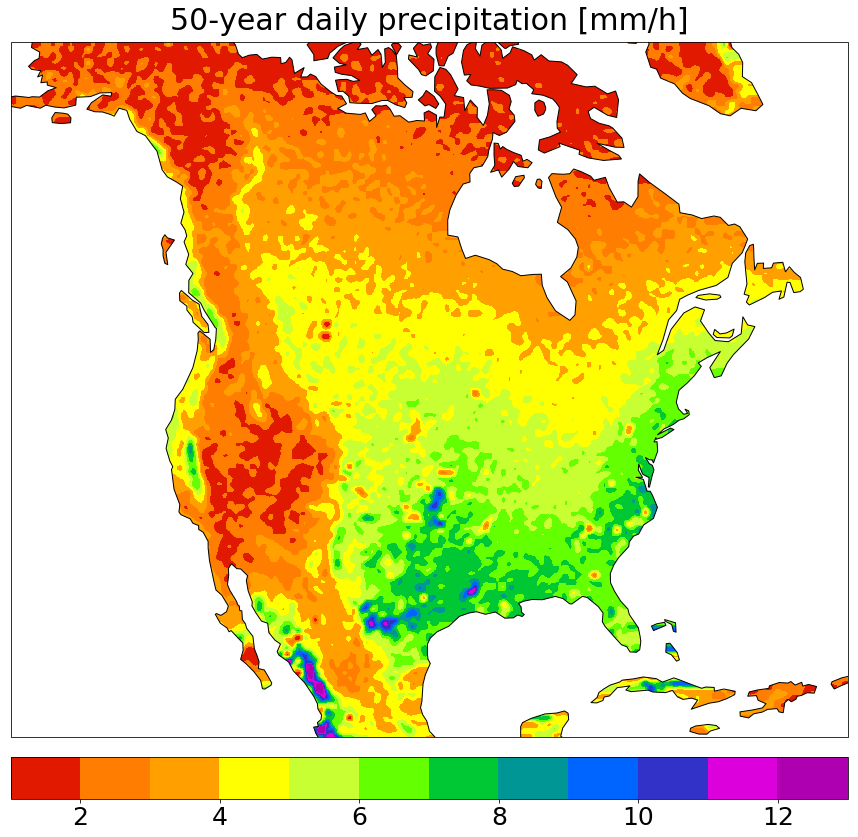

In [20]:
MapXtreme.plot_reference(df_interp, run = 'run_full_eof_interp')